# Quantum Key Distribution

## Imports

In [2]:
# boilerplate
import numpy as np
import pandas as pd
import matplotlib as plt
import os

# qiskit
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint
from qiskit.providers.aer import QasmSimulator

# other classes I wrote
import Alice
import Bob
import Eve
import Encrypt

## Some important notes

- The following is the simplified, general process of how QKD works (a specific, more formalized example is below):

    1. Alice generates a string of qubits to encode and a corresponding string of bases she wants to use for encoding (both private)
    2. Alice then encodes each bit in her string with the corresponding basis and sends this message to Bob
    3. Bob then measures each qubit at random from the encoded message
    4. Bob and Alice publicly share which bases they used for each qubit: if there is a match, they use that qubit to form part of a shared secret key
    5. Finally, Alice and Bob share a random sample of their generated keys. If they match, then the transmission was extremely likely to be successful
    
    $$ $$

- Fact: measuring a quibit can change its state. If Eve attempts to access the information contained in the qubit sent from Alice to Bob, i.e. by measuring it, then it is possible that the state of the qubit will be changed.

- Note: only run each cell once. Running multiple times might make the circuit look a litle weird.



## Demo 1: Without Interception

This first demo shows the QKD process in the abscene of an eavesdropper Eve attempting to listen in or otherwise tamper with the communication channel.

In [ ]:
# Run the following cell just to see if the classes work properly, 
# treating the encryption as an object and running the following methods on it

# e = Encrypt.Encrypt(32)
# print(e.run_without_intercept()) 
# print(e.run_with_intercept()) 

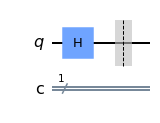

In [3]:
alice = Alice.Alice(100)
bob = Bob.Bob(100)
bits = alice.init_bitstring()
bases = alice.init_bases()
    
list = alice.encode_bitstring(bits, bases)
list[3].draw('mpl')

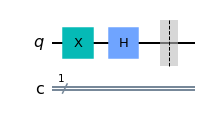

In [4]:
np.random.seed(seed=0)
n = 100

# Alice generates bits and bases
alice_bits = randint(2, size=n)
alice_bases = randint(2, size=n)

message = alice.encode_bitstring(alice_bits, alice_bases)
message[7].draw('mpl') # a single encoded qubit in the single-qubit circuit

Bob's results: [0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1]


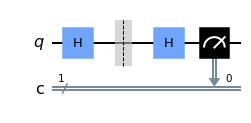

In [5]:
# now bob measures the message in a random sequence of bases of his choosing
bob_bases = randint(2, size=n)
bob_results = bob.measure_message(message, bob_bases) # this is the result for step 3.. bob keeps this result private
print(f'Bob\'s results: {bob_results}')
message[0].draw('mpl')

In [6]:
message[6].draw('mpl')
print(len(bob_results))

100


In [7]:
alice_key = alice.remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = bob.remove_garbage(alice_bases, bob_bases, bob_results)
print(f'Alice key = {alice_key}')
print(f'Bob key = {bob_key}')
print()

print(f'Len_alice = {len(alice_key)}')
print(f'Len_bob = {len(bob_key)}')
print()

print(alice_key == bob_key)

# now testing a random sample to make sure the protocol worked correctly
sample_size = 16
bit_selection = randint(n, size=sample_size)

bob_sample = bob.share_random_sample(bob_key, bit_selection)
print("bob_sample = " + str(bob_sample))
alice_sample = alice.share_random_sample(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))


# if successful, true (with very high probability)
print(bob_sample == alice_sample) 

Alice key = [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]
Bob key = [0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]

Len_alice = 48
Len_bob = 48

True
bob_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
alice_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
True


## Demo 2: With Interception

This second demo experiments Eve's tampering with the encoded message using her own bases.

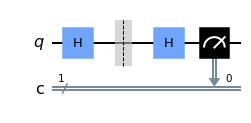

In [8]:
alice = Alice.Alice(32)
bob = Bob.Bob(32)
eve = Eve.Eve(32) # now, we need an eavesdropper


alice_bits = alice.init_bitstring()
alice_bases = alice.init_bases()
    
message = alice.encode_bitstring(alice_bits, alice_bases)
message[0].draw('mpl')

[1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0]


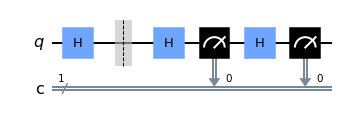

In [9]:
eve_bases = eve.init_bases()
intercept_message = eve.intercept_message(message, eve_bases)
print(intercept_message)
message[0].draw('mpl')

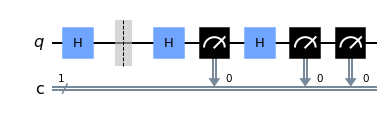

In [10]:
# Bob then checks like before and measures the message with his own choice of bases
bob_bases = bob.init_bases()
bob_results = bob.measure_message(message, bob_bases)
message[0].draw('mpl')

In [12]:
# just like before, Bob and Alice reveal choice of basis over Eve's public channel
bob_key = bob.remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = alice.remove_garbage(alice_bases, bob_bases, alice_bits)

In [13]:
sample_size = 15
bit_selection = randint(32, size=sample_size)
bob_sample = bob.share_random_sample(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = alice.share_random_sample(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1]
alice_sample = [1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1]


In [14]:
# either due to noise or eavesdropping, the message in void
print(bob_sample == alice_sample)

False


## The First Quantum Cryptographic Protocol: BB84


The following runs a very common algorithm when it comes to QKD. As an example, it outputs a circuit with $n$ qubits to see a visual of the quantum circuit. Known as the BB84, this QKD scheme was the first quantum protocol to be developed. This is a slighlty more specficic version of the the general QKD protocol described above. It just uses some more formal notation.

1. First, Alice prepares two bitstrings $a_i$ and $b_i$ that are $n$ bits long, encoding them in the following tensor product,

$$ |\psi\rangle = \bigotimes_{i=1}^{n}|\psi_{a_ib_i}\rangle. $$

These combinations result in four possible states after the encoding:

$$ |\psi_{00}\rangle = |0\rangle \\
|\psi_{10}\rangle = |1\rangle $$

are the simply the $\textbf{0}$ and $\textbf{1}$ states, but there is also

$$ |\psi_{01}\rangle = |+\rangle = \frac{1}{\sqrt{2}}|0\rangle + \frac{1}{\sqrt{2}}|1\rangle \\
|\psi_{11}\rangle = |-\rangle = \frac{1}{\sqrt{2}}|0\rangle - \frac{1}{\sqrt{2}}|1\rangle, $$

which are also two very important states called Bell States, as they are maximally entangled. The bit $b_i$ is what decides which basis $a_i$ is encoded in. But because the qubits are in states that aren't mutually orthogonal, the linear combination of states might not produce the trivial solution and hence, it is impossible to distinguish all of them with certainty without knowing $b_i$.

2. Next, Alice sends her encoded message $|\psi\rangle $ to Bob over the public quantum channel. Because of the existence of potential eavesdropping from like we discussed above and quantum noise, let $B(|\psi\rangle|\psi\rangle)$ be the function representing the message Bob recieves from Alice.
3. After Bob receives the string of qubits, both Bob and Eve have their own states. However, since only Alice knows $b$, it makes it virtually impossible for either Bob or Eve to distinguish the states of the qubits. Also, after Bob has received the qubits, we know that Eve cannot be in possession of a copy of the qubits sent to Bob, by the no-cloning theorem, unless she has made measurements. Her measurements, however, risk disturbing a particular qubit with probability 0.5 if she guesses the wrong basis.
4. Now, Bob generates his own key the same length as what he recieved from Alice. Call this $b_{Bob}$. He measures the qubits recieved from Alice, obtaining a bit string which we'll call $a_{Bob}$. 
5. Bob announces publicly that he has received Alice's transmission.
6. Alice then knows she can now safely announce $b$, i.e., the bases in which the qubits were prepared. Bob communicates over a public channel with Alice to determine which $b_i$ and $b_{i Bob}$ are not equal. Both Alice and Bob now discard the bits in $a$ and $a_{Bob}$ where $b$ and $b_{Bob}$ do not match (the $\texttt{remove_garbage}$ method).
7. From the remaining $k$ bits where both Alice and Bob measured in the same basis, Alice randomly chooses half of those bits and discloses her choices over the public channel. Both Alice and Bob announce these bits publicly and run a check to see whether more than a certain number of them agree. If this check passes, Alice and Bob have a shared, secret key.

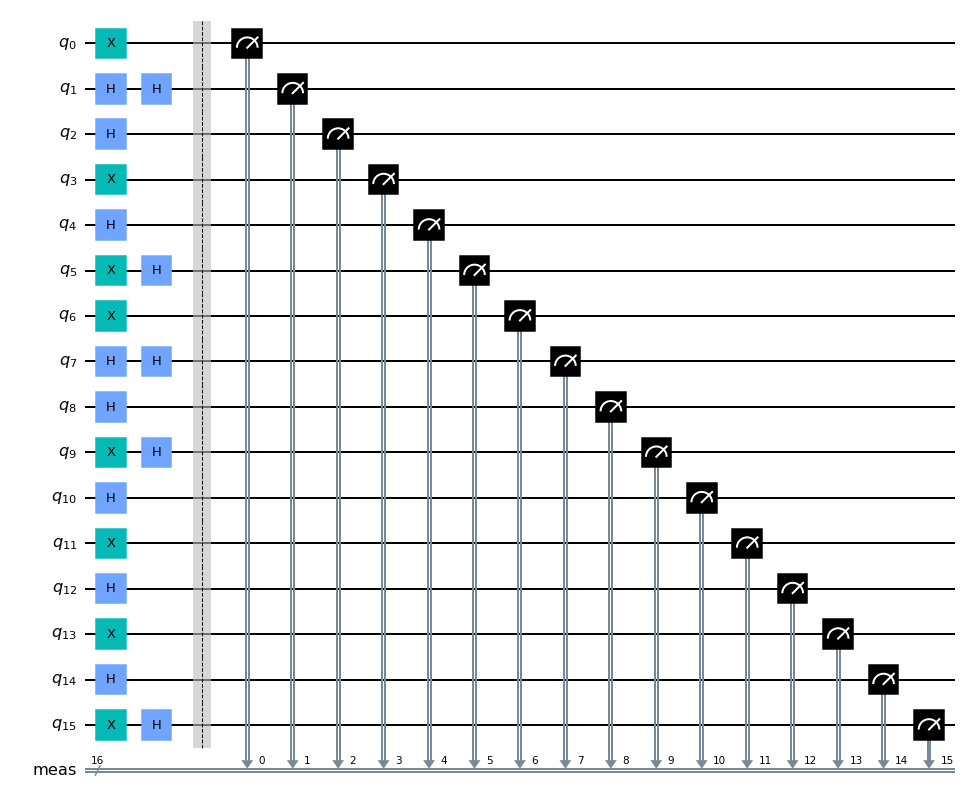

In [15]:
def bb84(state, basis, measurement):
    """
    Run the BB84 algorithm to run the QKD protocol
        @params:
            state       - Required  : the state of the qubits that want to be transmitted (int)
            basis       - Required  : the basis used to encode the state paramter above
            measurement - Required  : the measurement basis used when reciving the encoded message from the basis
                                      paramter

    """
    # initialize the circuit
    size = len(state)
    qc = QuantumCircuit(size)
    
    # iterate over the qubits in the basis: 
    # if 1, apply Pauli X, if 0, apply Hadamard
    for i in range(len(basis)):
        if state[i] == 1:
            qc.x(i)
        if state[i] == 0:
            qc.h(i)
    # after a transformation is applied to each qubit, measure
    for i in range(len(measurement)):
        if measurement[i] == 1:
            qc.h(i)
    # in the end, measures all of the qubits 
    qc.measure_all() 
    
    return qc
    
num_qubits = 16

# these can be changed using the bases and bits from the QKD protocol determined above, but have been randomized
# for the sake of speed up 
#
alice_basis = np.random.randint(2, size=num_qubits)
alice_bits = np.random.randint(2, size=num_qubits)
bob_basis = np.random.randint(2, size=num_qubits)

bb84(alice_bits, alice_basis, bob_basis).draw('mpl')

# Notebook References
- https://qiskit.org/textbook/ch-algorithms/quantum-key-distribution.html#1.-Introduction
- https://en.wikipedia.org/wiki/BB84
